# Лабораторная работа №7 по вычислительной математике
## Применение неявных методов в решении жесткой системы дифференциальных уравнений.
### Выполнил Филиппенко Павел -- студент группы Б01-009

##### Задание X.9.5

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
from scipy.integrate import ode

# исходники для решения СЛАУ
import SlaeAPI

#### Электрофизиология. Уравнение Бонгоффера-Ван-дер-Поля

$$
\begin{cases}
y_1' = a \left(- \left(\frac{y_1^3}{3} - y_1 \right) + y_2 \right) \\
y_2' = -y_1 - b y_2 + c
\end{cases}
$$

$$y_1(0) = 2, ~~~ y_2(0) = 0$$

В этом уравнении рассматриваются $a = 10^3$ и $a = 10^6$. Коэффициенты $c, b$ таковы, что $0 < c < 1$, $b > 0$.

In [43]:
# Задаем параметры системы
A = 1e3
# A = 1e6
C = 0.5
B = 1
y01 = 2
y02 = 0

In [44]:
# Задаем функции правой части
def f1(y1, y2):
    return A * (-(y1**3 / 3 - y1) + y2)

def f2(y1, y2):
    return -y1 -B*y2 + C

def F(y):
    y1 = y[0]
    y2 = y[1]
    return np.array([
        f1(y1, y2),
        f2(y1, y2)
    ])

Для решения данной жесткой системы мы будем использовать трехстадийный метод Розенброка.

In [45]:
# коэффициенты для трехстадийного метода Розенброка
a  = 0.435866521508459
p1 = 0.435866521508459
p2 = 0.4782408332745185
p3 = 0.0858926452170225 
beta21 = 0.435866521508459
beta31 = 0.435866521508459
beta32 = -2.116053335949811

In [46]:
# Якобиан системы в точке yn (считаем численно)
def J(yn, h):
    y1n = yn[0]
    y2n = yn[1]

    df1dx1 = (f1(y1n + h, y2n) - f1(y1n - h, y2n)) / (2*h)
    df1dx2 = (f1(y1n, y2n + h) - f1(y1n, y2n - h)) / (2*h)
    df2dx1 = (f2(y1n + h, y2n) - f2(y1n - h, y2n)) / (2*h)
    df2dx2 = (f2(y1n, y2n + h) - f2(y1n, y2n - h)) / (2*h)

    res = np.array([
        [df1dx1, df1dx2],
        [df2dx1, df2dx2]
    ])
    return res

# Дифференциальный оператор
def Dn(yn, h):
    E = np.eye(2)
    return E + a * h * J(yn, h/10)

In [47]:
# Трехстадийный метод Розенброка
def Rozenbrok3Mthd(f, h, t_start, t_end, initial_solution: tuple):
    t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))
    solution = np.zeros((int((t_end-t_start)/h+1), 2))
    solution[0] = initial_solution
    
    for i in range(len(t)-1):
        # При решении был использован код для численного решения системы линейных уравнений, 
        # написанный в другой лабораторной.
        # Можно использовать библиотечную функцию np.linalg.solve(A, f)
        slae1 = SlaeAPI.Slae(Dn(solution[i], h), h*f(solution[i]))
        k1 = slae1.Gauss_mthd()
        slae2 = SlaeAPI.Slae(Dn(solution[i], h), h*f(solution[i] + beta21*k1))
        k2 = slae2.Gauss_mthd()
        slae3 = SlaeAPI.Slae(Dn(solution[i], h), h*f(solution[i] + beta31*k1 + beta32*k2))
        k3 = slae3.Gauss_mthd()
        # получаем y_{n+1}
        solution[i+1] = solution[i] + p1*k1 + p2*k2 + p3*k3
    return solution

In [48]:
h = 0.0001
init_sol = np.array([2, 0])
t_start = 0
t_end = 100

sol = Rozenbrok3Mthd(F, h, t_start, t_end, init_sol)
y1_comp, y2_comp = sol.T
t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))

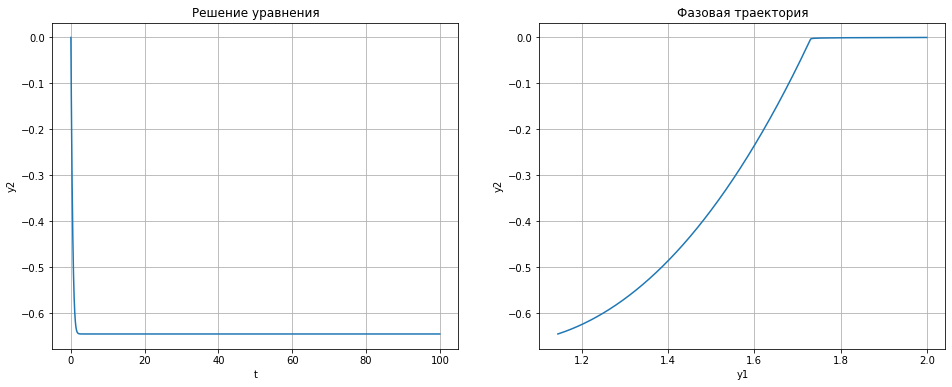

In [49]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(t, y2_comp)
plt.title('Решение уравнения')
plt.xlabel('t')
plt.ylabel('y2')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(y1_comp, y2_comp)
plt.title('Фазовая траектория')
plt.xlabel('y1')
plt.ylabel('y2')
plt.grid()

Убедимся в правильности решения системы. Рассмотрим решение с помощью символьных вычислений и библиотечных функций.

In [50]:
y1, y2 =  smp.Symbol('y[0]'), smp.Symbol('y[1]')
a, b, c = smp.Symbol('a'), smp.Symbol('b'), smp.Symbol('c')

f1 = a*(-(y1**3/3 - y1) + y2)
f2 = -y1 - b*y2 + c

Y = smp.Matrix([f1, f2])
X = smp.Matrix([y1, y2])

In [51]:
f1

a*(-y[0]**3/3 + y[0] + y[1])

In [52]:
f2

-b*y[1] + c - y[0]

In [53]:
Y.jacobian(X)

Matrix([
[a*(1 - y[0]**2),  a],
[             -1, -b]])

In [54]:
def f(t, y, a, b, c):
  return [a*(y[0] + y[1] - y[0]**3/3),
          c - y[0] - b*y[1]]

def jac(t, y, a, b, c):
  return [[a*(1 - y[0]**2),  a],
          [             -1, -b]]

In [55]:
r = ode(f, jac).set_integrator('vode', method='bdf', with_jacobian=True)
r.set_initial_value((y01, y02)).set_f_params(A, B, C).set_jac_params(A, B, C)

t1, dt, t, y1, y2 = 100, 0.0001, [0.], [y01], [y02]
while r.successful() and r.t < t1:
    r.integrate(r.t + dt)
    t.append(r.t)
    y1.append(r.y[0])
    y2.append(r.y[1])

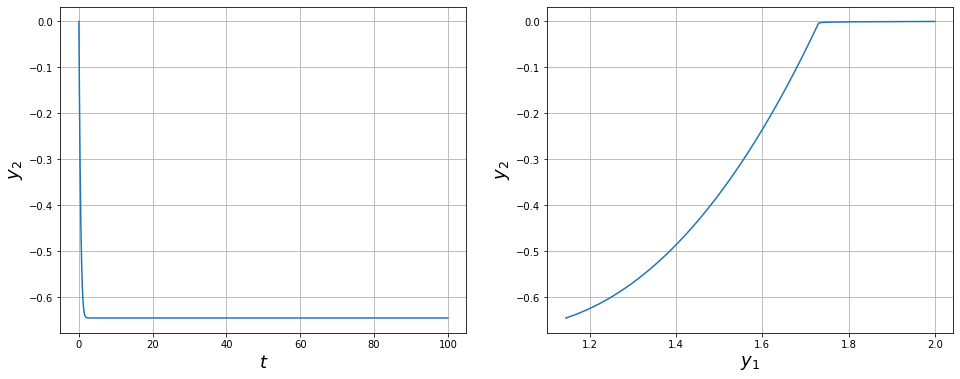

In [56]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.ylabel(r'$y_2$', {'fontsize': 18})
plt.xlabel(r'$t$', {'fontsize': 18})
plt.grid(True)
plt.plot(t, y2)

plt.subplot(1, 2, 2)
plt.ylabel(r'$y_2$', {'fontsize': 18})
plt.xlabel(r'$y_1$', {'fontsize': 18})
plt.grid(True)
plt.plot(y1, y2)

Сравним расхождение нашего решения с решением, полученным с помощью библиотечных функций.

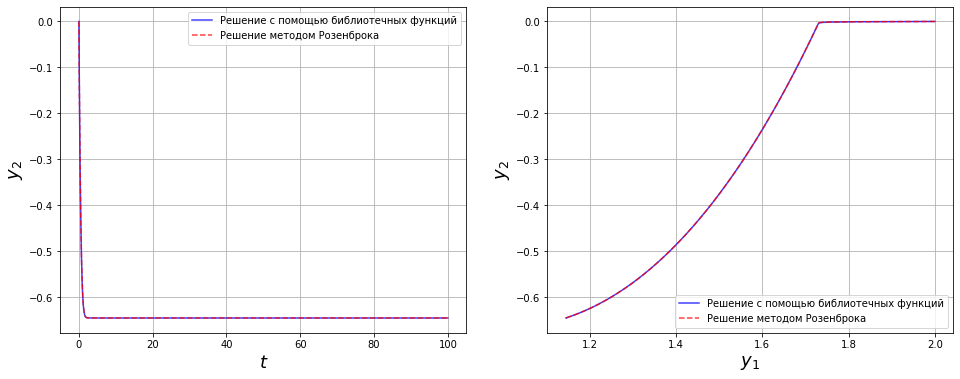

In [58]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.ylabel(r'$y_2$', {'fontsize': 18})
plt.xlabel(r'$t$', {'fontsize': 18})
plt.grid(True)
plt.plot(t, y2, color='blue', alpha=0.75, lw=1.5, ls='-', label='Решение с помощью библиотечных функций')
plt.plot(t, y2_comp, color='red', alpha=0.75, lw=1.5, ls='--', label='Решение методом Розенброка')
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel(r'$y_2$', {'fontsize': 18})
plt.xlabel(r'$y_1$', {'fontsize': 18})
plt.grid(True)
plt.plot(y1, y2, color='blue', alpha=0.75, lw=1.5, ls='-', label='Решение с помощью библиотечных функций')
plt.plot(y1_comp, y2_comp, color='red', alpha=0.75, lw=1.5, ls='--', label='Решение методом Розенброка')
plt.legend()

# Вывод

